# LSTM for stock market prediction?
<i>
In this jupyter notebook I will find out if LSTM has the potential to predict n numbers of days in the future based on one of the previous data sequences, essentially this aims to find patterns in time-series price data by this special RNN type.
<br/>
<br/>
<br/>
<br/>
<div style="text-align:center;">
    <img src="img/lstm_model.jpg" alt="LSTM" width="300"/>
</div>
<br/>
<br/>
<br/>
<br/>
Structure and Operation of LSTM</i>

 LSTM (Long Short-Term Memory) networks comprise specialized components that allow them to handle sequential data effectively. Within an LSTM, there are memory cells that store information for extended periods, making them suitable for capturing long-term dependencies in data sequences. Key to their operation are gates, including the forget gate, input gate, and output gate, which control the flow of information. The forget gate helps determine which information is less relevant and should be discarded, the input gate decides what new information is crucial and should be stored, and the memory cell calculates an updated state based on these considerations. Finally, the output gate selects the information to be used in the output. This complex architecture empowers LSTMs to address tasks requiring the understanding of sequential patterns, particularly those with extended time dependencies.
 - Long-short story is type of recurent neural network that is widely used in tasks involving sequential data - so, like stock market.
 - Standard neural networks or simple RNNs struggle to handle and manage long-term dependencies present in data sequences.
 What LSTM is applicatable for?
    - Speech recognition, Machine translation, Sentiment analysis in text, Stock price currency rates, time series analysis, such as weather forecasting, Automatic text and music generation.</i>


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense , Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

#df = pd.read_csv('../input/polish-stocks/EPOL.csv',index_col=0)["Adj Close"]
#print(df.head(2))

Date
2010-05-26    17.905886
2010-05-27    18.939611
Name: Adj Close, dtype: float64


In [4]:
#!pip install yfinance
import yfinance as yf
df = yf.download('EPOL')["Adj Close"].dropna()
print(df.isnull().sum())
print(df.tail())
df.to_csv("EPOL.csv")

Normalize data. We them process them from 0 to 1 as this is standard method, and data does not have extreme values sticking out

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values.reshape(-1, 1))

Sequence will look for 40 days back, and 20 days ahead to forecast

In [6]:
def create_dataset(data, look_back, X_day_ahead):
    X, y = [], []
    for i in range(len(data) - look_back - X_day_ahead):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back:i + look_back + X_day_ahead, 0])
    return np.array(X), np.array(y)

X_day_ahead = 20 
look_back = 40

X, y = create_dataset(data_scaled, look_back, X_day_ahead)
print(X.shape, y.shape)

(3312, 40) (3312, 20)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [8]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 1), return_sequences=True))
model.add(Dropout(0.02))  # Add dropout to the first LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.02))  # Add dropout to the second LSTM layer
model.add(LSTM(128))
model.add(Dense(X_day_ahead))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 40, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 40, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 20)                2580      
                                                                 
Total params: 332,308
Trainable params: 332,308
Non-trai

In [9]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])

# Set up early stopping callback
callback = [EarlyStopping(patience=10, restore_best_weights=True)]

# Train the model
history = model.fit(X_train, y_train, validation_split=0.3, callbacks=callback, epochs=200, batch_size=32, verbose=1)


Epoch 1/200
66/66 [==============================] - 9s 27ms/step - loss: 0.0306 - mean_absolute_error: 0.1094 - mean_squared_error: 0.0306 - val_loss: 0.0067 - val_mean_absolute_error: 0.0596 - val_mean_squared_error: 0.0067
Epoch 2/200
66/66 [==============================] - 1s 12ms/step - loss: 0.0055 - mean_absolute_error: 0.0580 - mean_squared_error: 0.0055 - val_loss: 0.0062 - val_mean_absolute_error: 0.0603 - val_mean_squared_error: 0.0062
Epoch 3/200
66/66 [==============================] - 1s 11ms/step - loss: 0.0049 - mean_absolute_error: 0.0546 - mean_squared_error: 0.0049 - val_loss: 0.0059 - val_mean_absolute_error: 0.0576 - val_mean_squared_error: 0.0059
Epoch 4/200
66/66 [==============================] - 1s 12ms/step - loss: 0.0046 - mean_absolute_error: 0.0525 - mean_squared_error: 0.0046 - val_loss: 0.0061 - val_mean_absolute_error: 0.0556 - val_mean_squared_error: 0.0061
Epoch 5/200
66/66 [==============================] - 1s 11ms/step - loss: 0.0046 - mean_absolute

In [10]:
pred_test = model.predict(X_test)

11/11 [==============================] - 1s 5ms/step


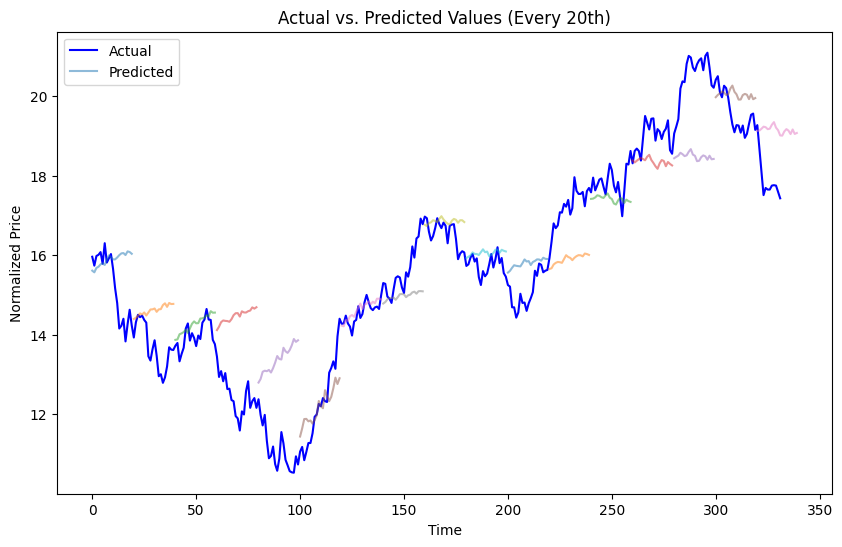

In [11]:

# Select the first value from each frame in y_test
# Select every X_day_ahead frame for better graph outlook
real =  scaler.inverse_transform(y_test[:, 0].reshape(-1, 1))
pred =  scaler.inverse_transform(pred_test[::X_day_ahead].reshape(-1, 1)).reshape(-1,X_day_ahead)

plt.figure(figsize=(10, 6))
plt.plot(real, label='Actual', color='blue')

# Plot every x frame from pred_test
for i in range(len(pred)):
    plt.plot(range(i * 20, (i + 1) * 20), pred[i], alpha=0.5)

plt.title('Actual vs. Predicted Values (Every 20th)')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend(['Actual', 'Predicted'])
plt.show()


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate error metrics
mae = mean_absolute_error(y_test, pred_test)
mse = mean_squared_error(y_test, pred_test)
rmse = np.sqrt(mse)

print("MAE:",round(mae,4))
print("MSE:",round(mse,4))
print("RMSE:",round(rmse,4))




MAE: 0.0462
MSE: 0.0035
RMSE: 0.0595


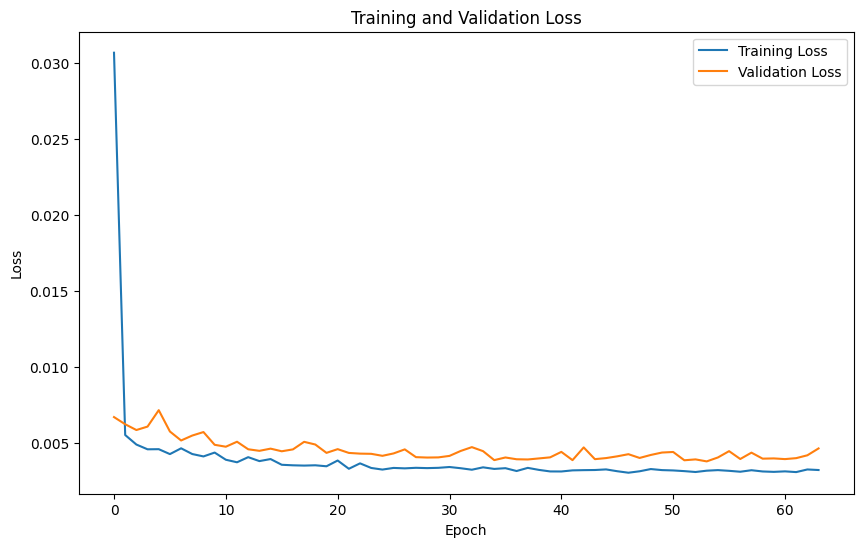

In [18]:
# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The data suggests that, as with forecasting one day ahead, forecasts tends closing near the mean value. Losses across epochs suggest that the model is not significantly improving; only the use of the EarlyStopping module prevents overfitting and it's stay at 0.005 loss for validation set. Interestingly, predictions made at 20-day intervals appear to show some similarity in pattern. This suggests that training data such as stock prices is likely too noisy, variable for this RNN model and does not add any value to the direction or behavior of price movements. 
It look that this estimation is more like averaging the output results over all time frames in the past.